In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# Plotting settings
a_min = 1e-3
a_max = 1
margin = 1.3

# Linear predictions

In [2]:
# from astropy.cosmology import Planck18_arXiv_v2 as cosmo

In [3]:
import sympy as sym

import numpy as np
from sympy import symbols, sqrt, lambdify, Function, solve, Derivative, init_printing, exp, pi, sympify, nsimplify, Float, N
init_printing()
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline

In [4]:
plt.style.use('./my_style.py')
import matplotlib.ticker as mticker

from cycler import cycler
import matplotlib.cm     as cm

In [5]:
#Symbolic variables
x, y, mu, k, E_diffa= symbols(r' x, y, \mu, k, E_a')
a= symbols('a', positive=True)
D= Function('D')
E = Function('E')(a)

Om0  = symbols('O_m0')

In [6]:
Om0_val = nsimplify(0.3089)

Ol0 = 1- Om0_val
H0_hinvMpc= 1/2997.92458

In [7]:
H = H0_hinvMpc*E
H_LCDM = H0_hinvMpc*sqrt(Om0_val*a**(-3) + Ol0)
H_LCDM_Or = H0_hinvMpc*sqrt(Om0_val*a**(-3) + Ol0+ 8*10**(-5)*a**(-4))
H_conf = H*a
Om = Om0_val*a**(-3)
Ol = Ol0

# Background

#### $k$-mouflage

We use that:
- $\rho_m = 3 \Omega_m H_0^2 /(8 \pi G)$
- $\frac{d}{dt} = \frac{d}{a d\tau}$
- $\dot{\phi} = \phi^{\prime}/a$
- $\ddot{\phi} = \frac{d}{dt}(\phi^{\prime}/a) = \frac{1}{a^2}\phi^{\prime\prime} - \frac{1}{a^2} \phi^{\prime} \mathcal{H}$

and as above:
$$\frac{d}{d\tau} = a \mathcal{H} \frac{d}{da}$$

### Ben's Data

In [8]:
header_str = 'a,  H_MG,  H_LCDM, H_MG/H_LCDM,  aH dH/da / H0^2 ,  phi , d phi/ dlna'
header = [s.strip(' ')for s in header_str.split(',')]

df_Ben_BG = pd.DataFrame(np.loadtxt('./Data/Background/background_k01_glam.dat'), columns=header).set_index('a')

# Test solver

We first construct a solver that uses 3 variables:
- $\phi$
- $\phi_a \equiv \frac{d \phi}{d a}$
- $E_a \equiv \frac{d E}{d a}$

We compare its solutions to Ben's.

In [14]:
# lamb =1.476
lamb_val = nsimplify(1.476)
lamb =symbols(r'\lambda')
beta=0.2 
n=2
K0=1
H0_target=1
a_ini=3e-5
a_fin=2

phi_p, phi_pp, X, rho_m, G = symbols(r'\phi^{\prime}, \phi^{\prime\prime}, X, \rho_m, G')
phi = Function(r'\phi')(a)
phi_d, phi_dd = symbols(r'\dot{\phi}, \ddot{\phi}')
phi_a = symbols(r'\phi_a')

phi_p = a*H_conf*phi.diff(a)
phi_pp = a*H_conf*(phi_p).diff(a)

A = exp(beta*phi)
rho_m = (Om*H0_hinvMpc**2/(8*pi*G/3))#.evalf(30) # convert rho_m into Om
phi_d = phi_p/a
phi_dd = phi_pp/a**2 - phi_p/a**2*H_conf

K = (-1 + X + K0*X**n)
K_x = K.diff(X)
K_xx = K_x.diff(X)
X_bar = phi_p**2/(2*lamb**2 * a**2 * H0_hinvMpc**2)
K_x_bar = K_x.subs(X, X_bar)
K_xx_bar = K_xx.subs(X, X_bar)

kmou_back = ((K_x + 2*X*K_xx)*phi_dd + 3*H*K_x*phi_d + A.diff(phi)*8*pi*G * rho_m).evalf(n=30, subs={Om0:Om0_val})
H_kmou_sq = rho_m/3*8*pi*G*A+(K_x*phi_d**2/3 - lamb**2*K*H0_hinvMpc**2/3) -H**2

E_kmou_a_eq = (((-4*pi*G*A*rho_m - K_x*phi_d**2/2 - lamb**2*H0_hinvMpc**2*K)/3-H**2)/H_conf/H0_hinvMpc).evalf(n=30, subs={Om0:Om0_val})

dphia_o_da_sym_eq = solve(kmou_back.subs(phi.diff(a),phi_a),Derivative(phi_a,a))[0]
dphia_o_da_sym_eq = dphia_o_da_sym_eq.subs(E.diff(a), E_kmou_a_eq).subs(X, X_bar).subs(phi.diff(a),phi_a)

# dphia_o_da_sym_eq = solve(kmou_back.subs(E.diff(a),E_kmou_a_eq).subs(phi.diff(a),phi_a), Derivative(phi_a,a))[0]
dE_o_da_sym_eq = E_kmou_a_eq.subs(X, X_bar).subs(phi.diff(a),phi_a)

dphi_o_da_eq = lambdify((a, phi, phi_a, E), phi_a)
dphia_o_da_eq = lambdify((a, phi, phi_a, E), dphia_o_da_sym_eq.evalf(30, subs={lamb:lamb_val}),
                        modules='mpmath')
dE_o_da_eq = lambdify((a, phi, phi_a, E), dE_o_da_sym_eq.evalf(30, subs={lamb:lamb_val}),
                     modules='mpmath')


def dum_fun(t,vec):
    '''Dummy function to adapt the input of solve_ivp'''
    return (dphi_o_da_eq(t,vec[0],vec[1], vec[2]),
            dphia_o_da_eq(t,vec[0],vec[1], vec[2]),
           dE_o_da_eq(t,vec[0],vec[1], vec[2]))

# Compute the solution of the differential equation
H_kmou_sol = solve_ivp(dum_fun, t_span=(a_ini,a_fin), y0=(-0.1*a_ini, -1, H_LCDM.subs(a,a_ini)/H0_hinvMpc),
                       dense_output=True, rtol=1e-9,
                       method='LSODA',
                       atol=1e-9
                      )

<>:3: SyntaxWarning: invalid escape sequence '\L'
<>:3: SyntaxWarning: invalid escape sequence '\L'
/var/folders/_0/rw1qxx2x3ss_l_mx90qfbv740000gn/T/ipykernel_93362/2909306466.py:3: SyntaxWarning: invalid escape sequence '\L'
  axs[0].plot(H_kmou_sol['t'], lambdify(a,H_LCDM)(H_kmou_sol['t'])/H0_hinvMpc, 'k:', label='$\Lambda$CDM')


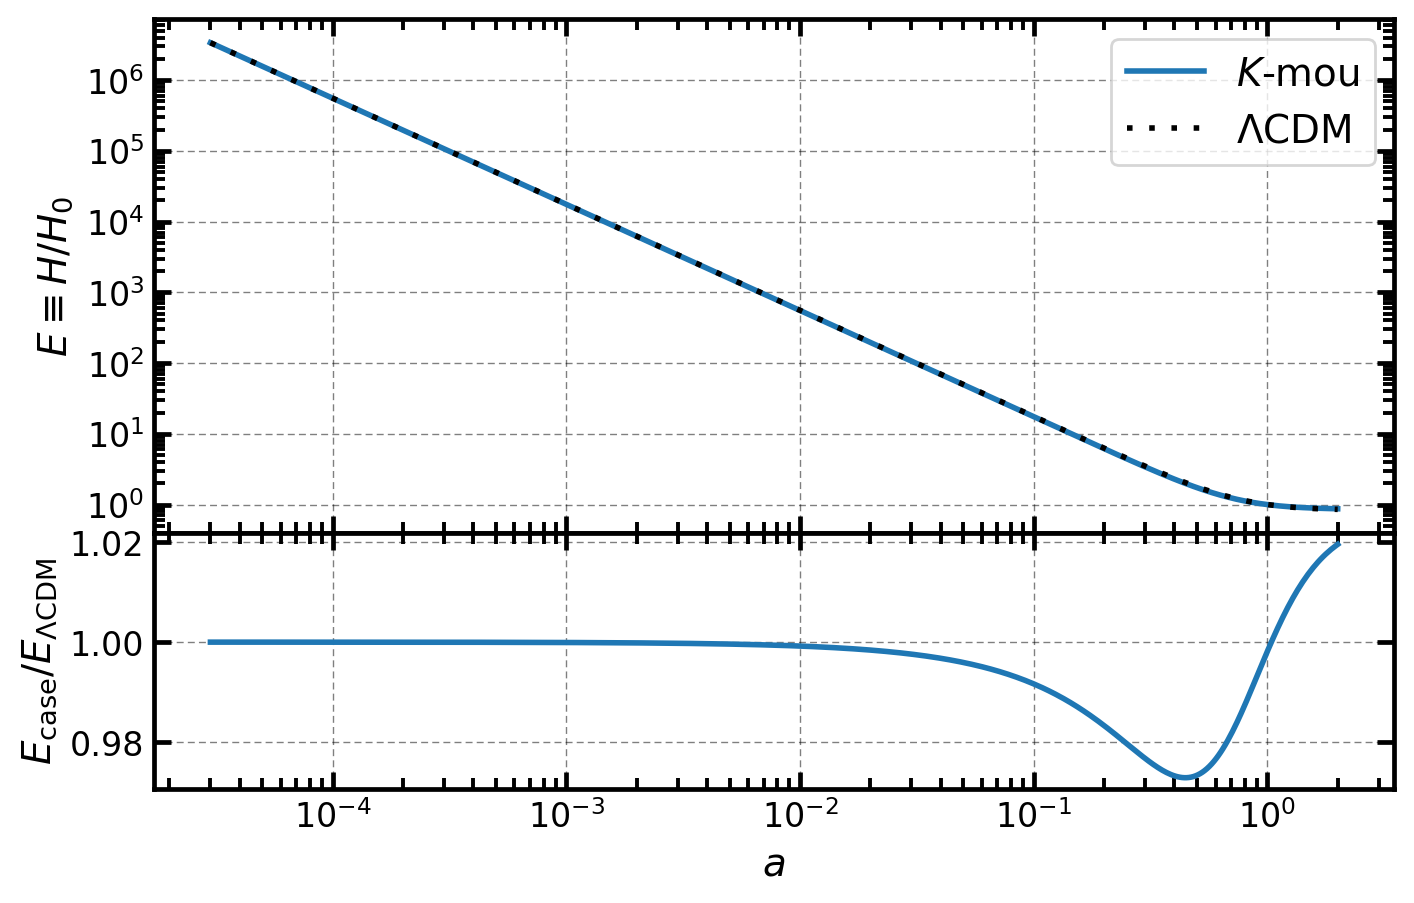

In [15]:
fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]), '-',label="$K$-mou")
axs[0].plot(H_kmou_sol['t'], lambdify(a,H_LCDM)(H_kmou_sol['t'])/H0_hinvMpc, 'k:', label='$\Lambda$CDM')

axs[0].legend();
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$E \equiv H/H_0$')

axs[1].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2])/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label="Bart's solver")
# axs[1].set_ylim(0.8,1.1)
axs[1].set_xlabel(r'$a$')
axs[1].set_ylabel(r'$E_{\rm case}/ E_{\rm \Lambda CDM}$')
fig.subplots_adjust(hspace=0);

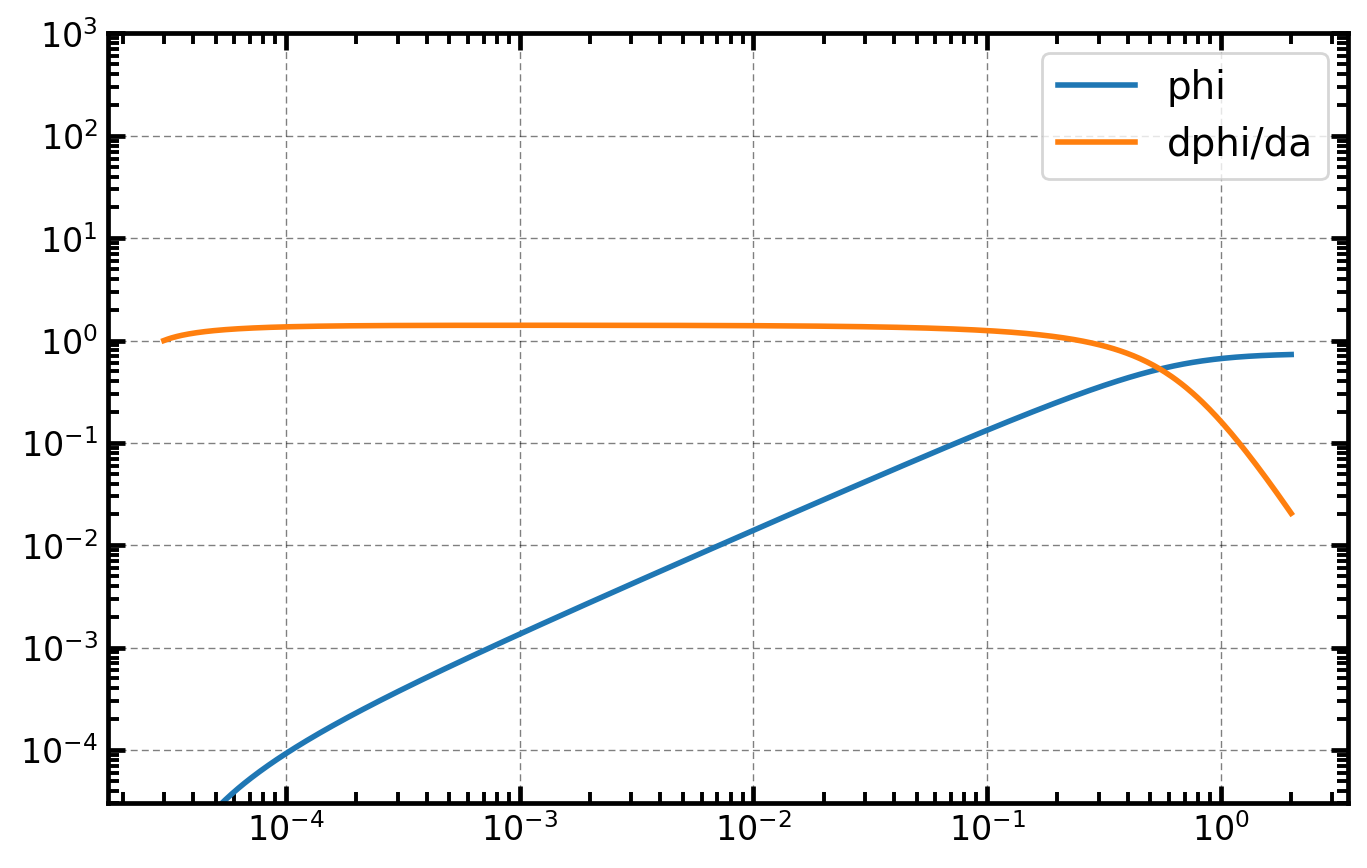

In [16]:
fig, ax = plt.subplots(1, sharex=True)
ax.plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][0]), label='phi')
ax.plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][1]), label='dphi/da')

ax.legend();
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(a_ini,1000);

<>:5: SyntaxWarning: invalid escape sequence '\L'
<>:5: SyntaxWarning: invalid escape sequence '\L'
/var/folders/_0/rw1qxx2x3ss_l_mx90qfbv740000gn/T/ipykernel_93362/269781583.py:5: SyntaxWarning: invalid escape sequence '\L'
  axs[0].plot(df_Ben_BG.index, lambdify(a,H_LCDM)(df_Ben_BG.index)/H0_hinvMpc, 'k:', label='$\Lambda$CDM')


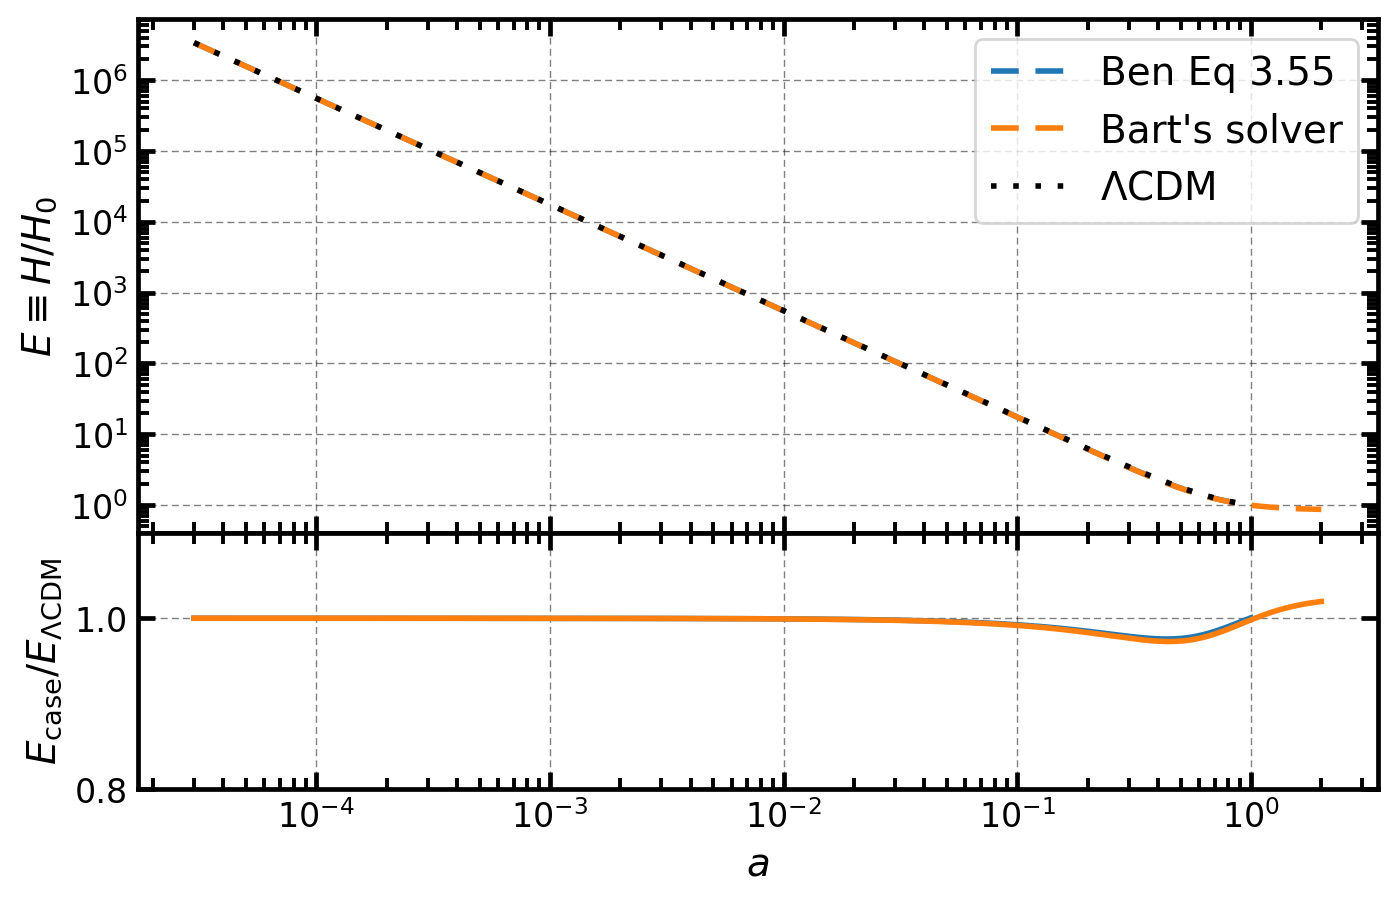

In [17]:
fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
# axs[0].plot(H_kmou_sol['t'], E_3p55, label='Bart Eq 3.55')
axs[0].plot(df_Ben_BG.index, df_Ben_BG['H_MG'], '--', label='Ben Eq 3.55' )
axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]), '--',label="Bart's solver")
axs[0].plot(df_Ben_BG.index, lambdify(a,H_LCDM)(df_Ben_BG.index)/H0_hinvMpc, 'k:', label='$\Lambda$CDM')

axs[0].legend();
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$E \equiv H/H_0$')

#axs[1].plot(H_kmou_sol['t'], E_3p55/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label='Bart Eq 3.55')
axs[1].plot(df_Ben_BG.index, df_Ben_BG['H_MG']/lambdify(a,H_LCDM)(df_Ben_BG.index)*H0_hinvMpc, label='Ben Eq 3.55' )
axs[1].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2])/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label="Bart's solver")
axs[1].set_ylim(0.8,1.1)
axs[1].set_xlabel(r'$a$')
axs[1].set_ylabel(r'$E_{\rm case}/ E_{\rm \Lambda CDM}$')
fig.subplots_adjust(hspace=0);

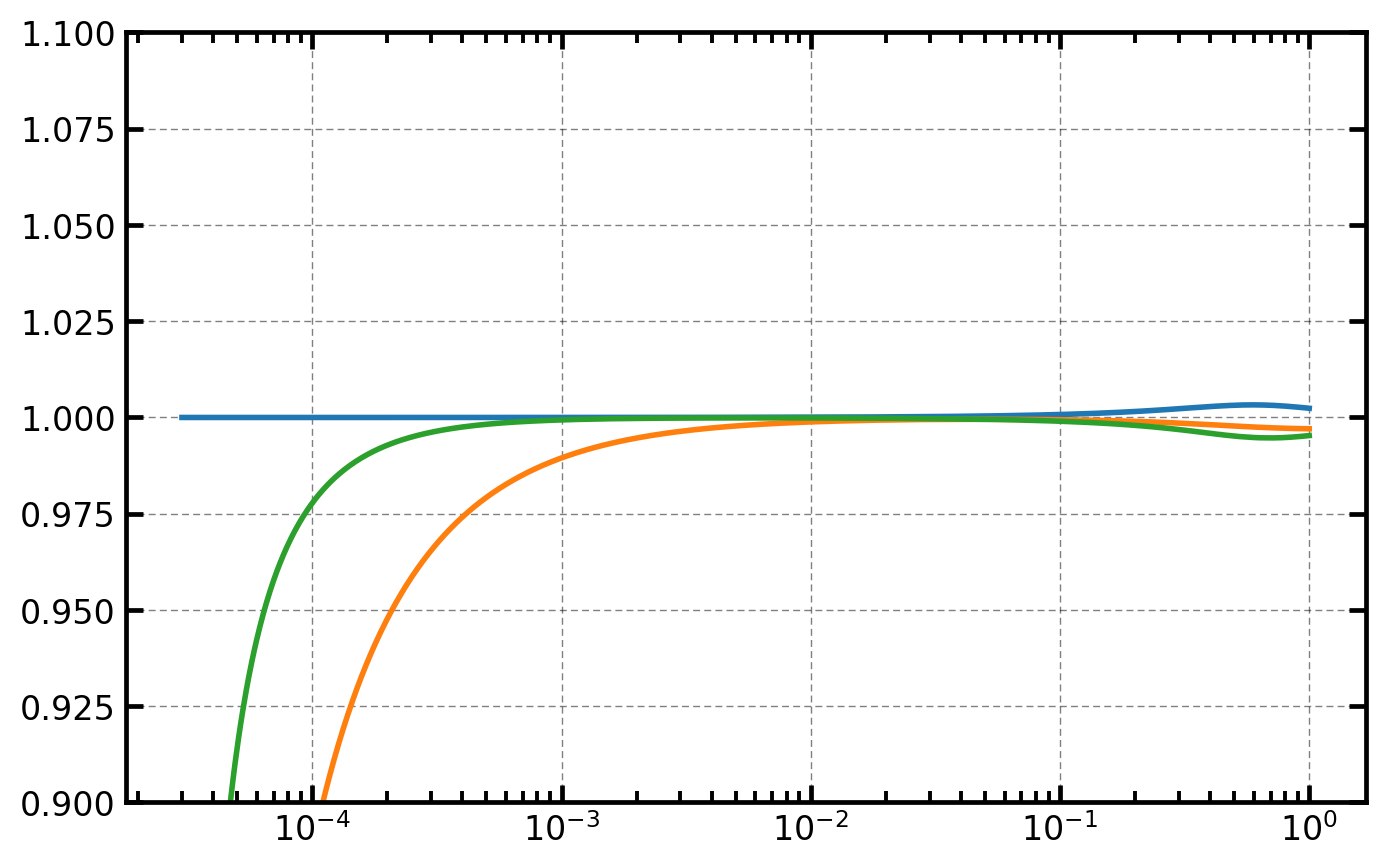

In [18]:
# plt.loglog(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]))
plt.semilogx(abs(df_Ben_BG['H_MG'])/H_kmou_sol.sol(df_Ben_BG.index)[2])
plt.semilogx((df_Ben_BG['phi'])/H_kmou_sol.sol(df_Ben_BG.index)[0])
plt.semilogx((df_Ben_BG['d phi/ dlna'])/H_kmou_sol.sol(df_Ben_BG.index)[1]/df_Ben_BG.index)
plt.ylim(0.9,1.1)

# Jordan frame

In [28]:
lamb =1.476
beta=0.2 
n=2
K0=1
H0_target=1
a_ini=3e-4
a_fin=2

In [29]:
phi_p, phi_pp, X, rho_m, G = symbols(r'\phi^{\prime}, \phi^{\prime\prime}, X, \rho_m, G')
phi = Function(r'\phi')(a)
phi_d, phi_dd = symbols(r'\dot{\phi}, \ddot{\phi}')
phi_a = symbols(r'\phi_a')

phi_p = a*H_conf*phi.diff(a)
phi_pp = a*H_conf*(phi_p).diff(a)

A = exp(beta*phi)
rho_m = Om*H0_hinvMpc**2/(8*pi*G/3) # convert rho_m into Om
rho_m0 = Om0_val*H0_hinvMpc**2/(8*pi*G/3) 
phi_d = phi_p/a
phi_dd = phi_pp/a**2 - phi_p/a**2*H_conf

K = (-1 + X + K0*X**n)
K_x = K.diff(X)
K_xx = K_x.diff(X)
X_bar = A**2 * phi_p**2/(2*lamb**2 * a**2 * H0_hinvMpc**2)
K_bar = K.subs(X, X_bar)
K_x_bar = K_x.subs(X, X_bar)
K_xx_bar = K_xx.subs(X, X_bar)

M_pl = 1/sqrt(8*pi*G) 
rho_phi = M_pl**2 * H0_hinvMpc**2 *lamb**2 / A**4 * (2*X_bar*K_x_bar - K_bar)
p_phi = M_pl**2 * H0_hinvMpc**2 *lamb**2 / A**4 * (K_bar)
O_phi = rho_phi/(3*H0_hinvMpc**2*M_pl**2)

eps2 = a*beta*phi.diff(a)
eps1 = 2*beta**2/K_x_bar

E_kmou_sq = A**2/(1-eps2)**2 * (Om + O_phi)
E_kmou = solve(E_kmou_sq - E**2, E)[1]
# E_kmou = sqrt((solve(E_kmou_sq.expand()- E**2, E**2)[-1]))

E_kmou_a = (- 3/2*H0_hinvMpc/H_conf* (A**2 / (1-eps2) *(Om + (rho_phi + p_phi)/(3*M_pl**2 *H0_hinvMpc**2)) + 
                                    2*A**2/(3*(1-eps2)**2)*(eps2 - 1/(1-eps2)*a*eps2.diff(a))*(Om + O_phi) )
                                    ).subs(phi.diff(a),phi_a)

In [38]:
dphia_o_da_sym_eq = H_conf * (A**(-2) * a**3 *H_conf *phi.diff(a)* K_x_bar).diff(a) + beta*rho_m0/M_pl**2

dphia_o_da_sym_eq = dphia_o_da_sym_eq.subs(E.diff(a), E_kmou_a)
dphia_o_da_sym_eq = solve(dphia_o_da_sym_eq.subs(phi.diff(a), phi_a), Derivative(phi_a, a))[0]

dphi_o_da_eq = lambdify((a, phi, phi_a, E), phi_a)
dphia_o_da_eq = lambdify((a, phi, phi_a, E), dphia_o_da_sym_eq.evalf(30, subs={lamb:lamb_val}))
dE_o_da_eq = lambdify((a, phi, phi_a, E), E_kmou_a.subs(Derivative(phi_a, a), dphia_o_da_sym_eq).evalf(30, subs={lamb:lamb_val}))

def dum_fun(t,vec):
    '''Dummy function to adapt the input of solve_ivp'''
    return (dphi_o_da_eq(t,vec[0],vec[1], vec[2]),
            dphia_o_da_eq(t,vec[0],vec[1], vec[2]),
           dE_o_da_eq(t,vec[0],vec[1], vec[2]))

# Compute the solution of the differential equation
H_kmou_sol_J = solve_ivp(dum_fun, t_span=(a_ini,a_fin), y0=(-0.1*a_ini, -1, H_LCDM.subs(a,a_ini)/H0_hinvMpc),
                       dense_output=True, rtol=1e-9,
                       # method='BDF',
                       atol=1e-9
                      )

In [41]:
dphiada_sol = solve(dphia_o_da_sym_eq.subs(phi.diff(a), phi_a), Derivative(phi_a, a))

In [34]:
dphia_o_da_sym_eq = H_conf * (A**(-2) * a**3 *H_conf *phi.diff(a)* K_x_bar).diff(a) + beta*rho_m0/M_pl**2

dphia_o_da_sym_eq = dphia_o_da_sym_eq.subs(E.diff(a), E_kmou_a)
dphia_o_da_sym_eq = solve(dphia_o_da_sym_eq.subs(phi.diff(a), phi_a), Derivative(phi_a, a))[0]
dphia_o_da_sym_eq = dphia_o_da_sym_eq.subs(E, E_kmou).subs(phi.diff(a), phi_a).subs(lamb, lamb_val)

dphi_o_da_eq = lambdify((a, phi, phi_a), phi_a)
dphia_o_da_eq = lambdify((a, phi, phi_a), dphia_o_da_sym_eq)

def dum_fun(t,vec):
    '''Dummy function to adapt the input of solve_ivp'''
    return (dphi_o_da_eq(t,vec[0],vec[1]),
            dphia_o_da_eq(t,vec[0],vec[1]))

# Compute the solution of the differential equation
H_kmou_sol_J = solve_ivp(dum_fun, t_span=(a_ini,a_fin), y0=(-0.1*a_ini, -1), dense_output=True, 
                       rtol=1e-9,
#                   method='Radau'
                      )

(1+ beta A a dphi/da) = d a_E / d a_J = ( d (a_E* A) / d a_E)^-1

d phi /da_J = (A+ beta A a dphi/da) * d phi /da_E

<>:4: SyntaxWarning: invalid escape sequence '\L'
<>:4: SyntaxWarning: invalid escape sequence '\L'
/var/folders/_0/rw1qxx2x3ss_l_mx90qfbv740000gn/T/ipykernel_93362/2773818415.py:4: SyntaxWarning: invalid escape sequence '\L'
  axs[0].plot(H_kmou_sol['t'], lambdify(a,H_LCDM)(H_kmou_sol['t'])/H0_hinvMpc, 'k:', label='$\Lambda$CDM')


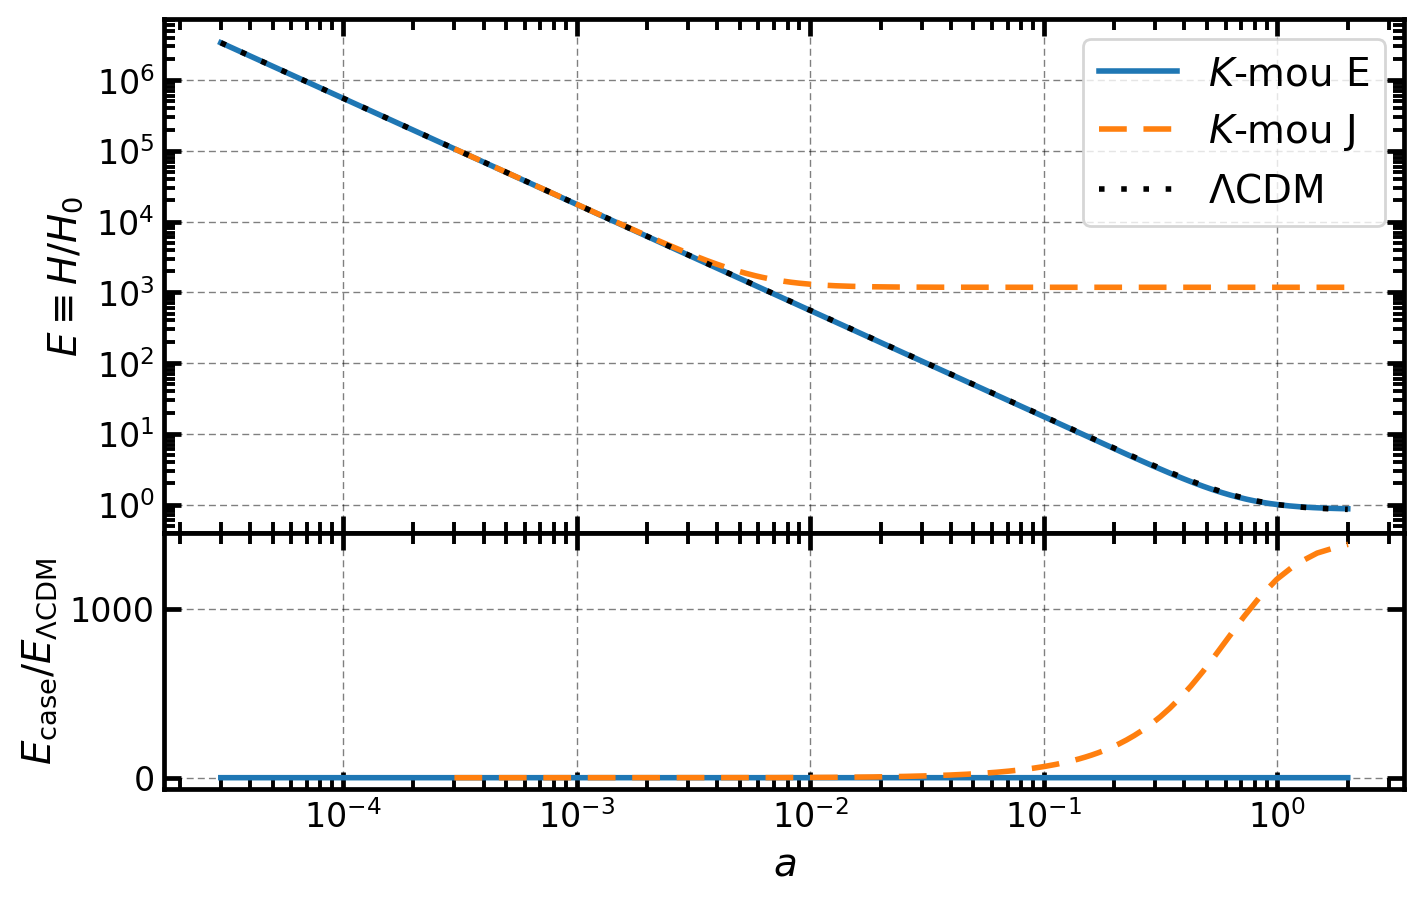

In [39]:
fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]), '-',label="$K$-mou E")
axs[0].plot(H_kmou_sol_J['t'], abs(H_kmou_sol_J['y'][2]), '--',label="$K$-mou J")
axs[0].plot(H_kmou_sol['t'], lambdify(a,H_LCDM)(H_kmou_sol['t'])/H0_hinvMpc, 'k:', label='$\Lambda$CDM')

axs[0].legend();
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$E \equiv H/H_0$')

axs[1].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2])/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc)
axs[1].plot(H_kmou_sol_J['t']/np.e**(beta*H_kmou_sol_J['y'][0]), abs(H_kmou_sol_J['y'][2])/lambdify(a,H_LCDM)(H_kmou_sol_J['t'])*H0_hinvMpc, '--')
# axs[1].set_ylim(0.8,1.1)
axs[1].set_xlabel(r'$a$')
axs[1].set_ylabel(r'$E_{\rm case}/ E_{\rm \Lambda CDM}$')
fig.subplots_adjust(hspace=0);

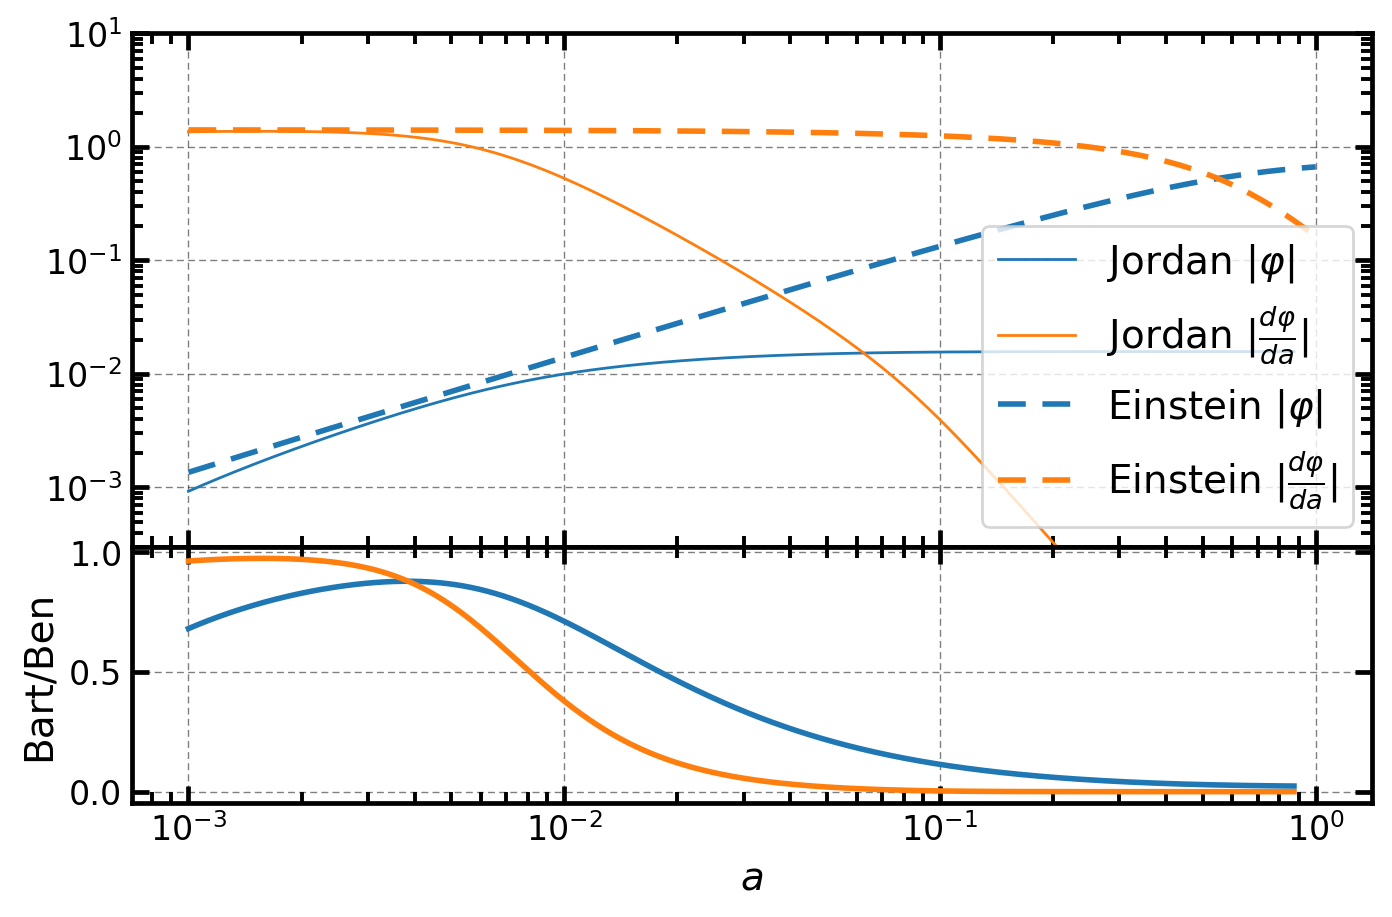

In [40]:
fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
a_vals_E = np.logspace(-3,0,1000)
a_vals_J = a_vals_E*np.e**(beta*H_kmou_sol.sol(a_vals_E)[0])
axs[0].plot(a_vals_J, abs(H_kmou_sol_J.sol(a_vals_J)[0]), lw=1,label=r'Jordan $|\varphi|$')
axs[0].plot(a_vals_J, abs(H_kmou_sol_J.sol(a_vals_J)[1]), lw=1,label=r'Jordan $|\frac{d \varphi}{da}|$')
axs[0].plot(a_vals_E, abs(H_kmou_sol.sol(a_vals_E)[0]), 'C0--',label=r'Einstein $|\varphi|$')
axs[0].plot(a_vals_E, abs(H_kmou_sol.sol(a_vals_E)[1]), 'C1--',label=r'Einstein $|\frac{d \varphi}{da}|$')

axs[0].legend();
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(a_ini,10)

axs[1].plot(a_vals_J, (H_kmou_sol_J.sol(a_vals_J)[0])/(H_kmou_sol.sol(a_vals_E)[0]), 'C0')
axs[1].plot(a_vals_J, (H_kmou_sol_J.sol(a_vals_J)[1])/(H_kmou_sol.sol(a_vals_E)[1]), 'C1')

# axs[1].set_ylim(0.95,1.05)
axs[1].set_xlabel(r'$a$')
axs[1].set_ylabel(r'Bart/Ben')
fig.subplots_adjust(hspace=0);

# Jordan frame function

In [ ]:
def solve_Kmou_expansion_Jordan(lamb=0.01, beta=0.2, n=2, K0=1, mode='search', H0_target=1, a_ini=3e-5, a_fin=1):
    phi_p, phi_pp, X, rho_m, G = symbols(r'\phi^{\prime}, \phi^{\prime\prime}, X, \rho_m, G')
    phi = Function(r'\phi')(a)
    phi_d, phi_dd = symbols(r'\dot{\phi}, \ddot{\phi}')
    # symbols for system of diff eq
    phi_a = symbols(r'\phi_a')
    
    phi_p = a*H_conf*phi.diff(a)
    phi_pp = a*H_conf*(phi_p).diff(a)
    
    A = exp(beta*phi)
    rho_m = Om*H0_hinvMpc**2/(8*pi*G/3) # convert rho_m into Om
    rho_m0 = Om0_val*H0_hinvMpc**2/(8*pi*G/3) 
    phi_d = phi_p/a
    phi_dd = phi_pp/a**2 - phi_p/a**2*H_conf
    
    K = (-1 + X + K0*X**n)
    K_x = K.diff(X)
    K_xx = K_x.diff(X)
    X_bar = A**2 * phi_p**2/(2*lamb**2 * a**2 * H0_hinvMpc**2)
    K_bar = K.subs(X, X_bar)
    K_x_bar = K_x.subs(X, X_bar)
    K_xx_bar = K_xx.subs(X, X_bar)
    
    M_pl = 1/sqrt(8*pi*G) 
    rho_phi = M_pl**2 * H0_hinvMpc**2 *lamb**2 / A**4 * (2*X_bar*K_x_bar - K_bar)
    p_phi = M_pl**2 * H0_hinvMpc**2 *lamb**2 / A**4 * (K_bar)
    O_phi = rho_phi/(3*H0_hinvMpc**2*M_pl**2)

    eps2 = a*beta*phi.diff(a)
    eps1 = 2*beta**2/K_x_bar
    
    E_kmou_sq = A**2/(1-eps2)**2 * (Om + O_phi)
    E_kmou = solve(E_kmou_sq - E**2, E)[1]
    E_kmou_a = - 3/2*H0_hinvMpc/H_conf* (A**2 / (1-eps2) *(Om + (rho_phi + p_phi)/(3*M_pl**2 *H0_hinvMpc**2)) + 
                                    2*A**2/(3*(1-eps2)**2)*(eps2 - 1/(1-eps2)*a*eps2.diff(a))*(Om + O_phi) )

    dphia_o_da_sym_eq = H_conf * (A**(-2) * a**3 *H_conf *phi.diff(a)* K_x_bar).diff(a) + beta*rho_m0/M_pl**2
    dphia_o_da_sym_eq = dphia_o_da_sym_eq.subs(E.diff(a), E_kmou_a)
    dphia_o_da_sym_eq = solve(dphia_o_da_sym_eq.subs(phi.diff(a), phi_a), Derivative(phi_a, a))[0]
    dphia_o_da_sym_eq = dphia_o_da_sym_eq.subs(E, E_kmou).subs(phi.diff(a), phi_a)
    
    dphi_o_da_eq = lambdify((a, phi, phi_a), phi_a)
    dphia_o_da_eq = lambdify((a, phi, phi_a), dphia_o_da_sym_eq)

    def dum_fun(t,vec):
        '''Dummy function to adapt the input of solve_ivp'''
        return (dphi_o_da_eq(t,vec[0],vec[1]),
                dphia_o_da_eq(t,vec[0],vec[1]))

    # Compute the solution of the differential equation
    H_kmou_sol = solve_ivp(dum_fun, t_span=(a_ini,a_fin), y0=(-1*a_ini*1e-15, -1), dense_output=True, 
                           rtol=1e-9,atol=1e-9,
                      method='LSODA'
                          )
    if mode=='search':
        E_kmou_fun =lambdify((a, phi, phi_a), E_kmou.subs(phi.diff(a), phi_a))
        return np.array(E_kmou_fun(1, H_kmou_sol.sol(1)[0], H_kmou_sol.sol(1)[1]) - H0_target)/H0_target
    elif mode=='phi':
        return H_kmou_sol
    elif mode=='full':
        E_kmou_fun =lambdify((a, phi, phi_a), E_kmou.subs(phi.diff(a), phi_a))
        E_kmou_a_fun =lambdify((a, phi, phi_a), E_kmou_a_eq.subs(X, X_bar).subs(phi.diff(a),phi_a).subs(E,E_kmou).subs(phi.diff(a), phi_a))
        return H_kmou_sol, E_kmou_fun, E_kmou_a_fun

In [ ]:
from scipy.optimize import newton

In [ ]:
# a_ini=3e-5
# best_lamb_J = newton(lambda l: solve_Kmou_expansion_Jordan(l, a_ini=a_ini, beta=0.2, K0=1, n=2), 1.4,maxiter=5)

In [ ]:
# H_kmou_sol, E_kmou_fun, E_kmou_a_fun = solve_Kmou_expansion_Jordan(10, beta=0.2, K0=1, n=3, mode='full', a_ini=3e-5)

# E_3p55 = np.array([E_kmou_fun(t,f,f_p) 
#                    for t,f,f_p in zip(H_kmou_sol['t'], H_kmou_sol['y'][0], H_kmou_sol['y'][1])])

# E_3p55_Ben = np.array([E_kmou_fun(t,f,f_p) for 
#                    t,f,f_p in zip(df_Ben_BG.index, df_Ben_BG['phi'], df_Ben_BG['d phi/ dlna']/df_Ben_BG.index)])

# E_3p56 = np.array([E_kmou_a_fun(t,f,f_p) 
#                    for t,f,f_p in zip(H_kmou_sol['t'], H_kmou_sol['y'][0], H_kmou_sol['y'][1])])

# E_3p56_Ben = np.array([E_kmou_a_fun(t,f,f_p) for 
#                    t,f,f_p in zip(df_Ben_BG.index, df_Ben_BG['phi'], df_Ben_BG['d phi/ dlna']/df_Ben_BG.index)])

# fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
# axs[0].plot(H_kmou_sol['t'], E_3p55, label='Jordan')
# axs[0].plot(df_Ben_BG.index, df_Ben_BG['H_MG'], label='Einstein' )
# # axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]), label="Bart's solver")
# axs[0].plot(df_Ben_BG.index, lambdify(a,H_LCDM)(df_Ben_BG.index)/H0_hinvMpc, 'k--', label='$\Lambda$CDM')

# axs[0].legend();
# axs[0].set_xscale('log')
# axs[0].set_yscale('log')
# axs[0].set_ylabel(r'$E \equiv H/H_0$')

# axs[1].plot(H_kmou_sol['t'], E_3p55/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label='Jordan')
# axs[1].plot(df_Ben_BG.index, df_Ben_BG['H_MG']/lambdify(a,H_LCDM)(df_Ben_BG.index)*H0_hinvMpc, '--',label='Einstein' )
# # axs[1].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2])/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label="Bart's solver")
# axs[1].set_ylim(0.86,1.03)
# axs[1].set_xlabel(r'$a$')
# axs[1].set_ylabel(r'$E_{\rm case}/ E_{\rm \Lambda CDM}$')
# fig.subplots_adjust(hspace=0);